# Detecting Topic Reference

Statistical analyses of the local/global classification experiment presented in Chapter 4.

Preprocessing:

- The `Coreferential` labels were replaced with `L`
- The duplicate text was removed
- The German nouns were translated into English

The comments were not modified.



In [10]:
import pandas as pd

df = pd.read_csv("../data/annotation/preprocessed.csv", index_col="shellnoun")

# create column multi-index
df.columns = pd.MultiIndex.from_tuples(
    [col.replace("_", "s_").split("_") for col in df]
)
df.head()

labels    ratings    comments  \
               A  B       A  B        A   
shellnoun                                 
fact           L  L       1  3      NaN   
fact           L  L       1  3      NaN   
fact           L  L       2  2      NaN   
fact           L  L       4  2      NaN   
fact           L  L       3  2      NaN   

                                                              
                                                           B  
shellnoun                                                     
fact       In meinen Augen keine Koreferenz i. e. S., da ...  
fact       Ich musst erst überlegen, ob der erste Abschni...  
fact       Scheint ein normaler Fall von Zugänglichmachun...  
fact       Hier scheint sich 'Tatsache' auf die im Satz z...  
fact       'Tatsache' stellt hier scheinbar die im letzte...

### Agreement ratio

In [11]:
agreements = df.labels.A.eq(df.labels.B)

print(f"Overall agreement: {agreements.mean():.2f}")

# per noun
agreements.groupby(level="shellnoun").mean().sort_values(ascending=False).round(2)

Overall agreement: 0.72


shellnoun
decision    0.80
problem     0.75
fact        0.74
issue       0.60
dtype: float64

### Confusion matrix

In [12]:
confusion = pd.crosstab(df.labels.A, df.labels.B)
confusion.loc[["L", "G", "U"], ["L", "G", "U"]]

B,L,G,U
A,,,
L,49,1,10
G,5,7,1
U,4,1,1


### Consensus categorization

<ipython-input-40-eebb8ce915c8>:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.filter(like="rating")
/Users/simonjetz/.local/share/virtualenvs/clustering-9qBh_5qX/lib/python3.9/site-packages/plot_likert/plot_likert.py:257: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.applymap(validate)


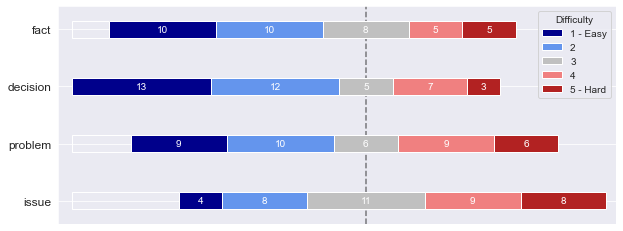

In [40]:
import plot_likert
import matplotlib.pyplot as plt
import seaborn as sns

scale = ["1 - Easy", "2", "3", "4", "5 - Hard"]

# create custom palette
palette = plot_likert.colors.default_with_darker_neutral
neutral, *colors_ = palette.copy()
colors = [neutral, *colors_[::-1]]

# visual settings
plt.rcParams["figure.figsize"] = (10, 4)
FONTSIZE = 16
sns.set_style("darkgrid")


# pivot data
frame = (
    df.filter(like="rating")
    .stack()
    .droplevel(1)
    .map(dict(enumerate(scale, start=1)).get)
)

frame = (
    frame.groupby(level="shellnoun")
    .apply(pd.DataFrame.reset_index, drop=True)
    .unstack(level=0)
    .droplevel(0, axis=1)
)[["fact", "decision", "problem", "issue"]]

# plot the ratings
ax = plot_likert.plot_likert(frame, plot_scale=scale, colors=colors, width=0.3)
ax.xaxis.set_visible(False)

ax.legend(title="Difficulty", fontsize=FONTSIZE - 6, title_fontsize=FONTSIZE - 6)

# add bar labels
for bars in ax.containers[1:]:
    ax.bar_label(bars, label_type="center", fontsize=FONTSIZE - 6, color="white")

ax.tick_params(labelsize=FONTSIZE - 4)

### Inter-annotator agreement

In [16]:
import krippendorff as kd
from statsmodels.stats import inter_rater as irr

# translate labels into integer codes
numerical_labels = df.labels.astype("category").apply(lambda col: col.cat.codes)
alpha_total = round(
    kd.alpha(numerical_labels.values.T, level_of_measurement="nominal"), 4
)

print(f"Alpha={alpha_total}")

Alpha=0.3249


### Mann Whitney U test

In [36]:
from scipy.stats import mannwhitneyu
import numpy as np

numerical_ratings = df.ratings.stack().droplevel(1).astype("category").cat.codes


def get_mannwhitneyu_(noun1, noun2):
    labels1 = numerical_ratings.loc[noun1]
    labels2 = numerical_ratings.loc[noun2]

    U_value, p_value = mannwhitneyu(labels1, labels2, alternative="two-sided")

    return p_value


get_mannwhitneyu = np.vectorize(get_mannwhitneyu_)

nouns = df.index.unique()
p_values = pd.DataFrame(
    get_mannwhitneyu(nouns, nouns.values[:, None]), index=nouns, columns=nouns
)

p_values

shellnoun,fact,decision,problem,issue
shellnoun,,,,
fact,1.000000,0.443057,0.499465,0.039022
decision,0.443057,1.000000,0.150129,0.004391
problem,0.499465,0.150129,1.000000,0.191056
issue,0.039022,0.004391,0.191056,1.000000


## 